# Post processing the SWIFT ABL case

In [1]:
%%capture 

# Important libraries header information
# ----------------------------------

# change this directory as necessary
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'         # official version
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend  as amrwind
import numpy             as np
from matplotlib import cm
import re

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

## Postprocess Met-Mast data

Run this section if the met-mast data has not already been post-processed

In [2]:
# Helper functions to post-process met-mast data
naluhelperdir = '/projects/wind_uq/lcheung/Scitech2021_WakePOD/utilities'
sys.path.insert(1, naluhelperdir)
import windspectra
from scipy.io import loadmat

# Some helper functions
flatten = lambda x: x[0][0].reshape((len(x[0][0])))

def replacenan(x):
    xmean=np.mean(x[~np.isnan(x)])
    where_are_NaNs = np.isnan(x)
    x[where_are_NaNs]=xmean
    return x 

# Average the spectra over multiple locations
# given by locations in planefilelist
def avgSpectraMetfiles(planefilelist, Nsample=None, dt=0.01, zkey='sonic_32m',avgbins=[], datadir='./', verbose=True):
    # set initial values
    Suu_avg={}
    Svv_avg={}
    Sww_avg={}
    iplane = 0
    all_ulongavgs = []
    lent = 0
    # Loop through and get spectra
    for planefile in planefilelist:
        if not os.path.isfile(datadir+'/'+planefile): continue
        dat   = loadmat(datadir+'/'+planefile)
        torig = flatten(dat[zkey]['Time'])
        u     = replacenan(flatten(dat[zkey]['SonicU']))
        v     = replacenan(flatten(dat[zkey]['SonicV']))
        w     = replacenan(flatten(dat[zkey]['SonicW']))
        Nt    = len(torig)
        t     = np.arange(Nt)*0.01
        if (Nsample is not None) and (Nt<Nsample): continue
        #if ((iplane != 0) and (len(torig)<lent)): continue
        if verbose: print("Loaded plane "+planefile)
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        if (Nsample is None): Ntake = Nt
        else:                 Ntake = Nsample
        f, Suu      = windspectra.avgWindSpectra(t[:Ntake], ulong[:Ntake], avgbins)
        f, Svv      = windspectra.avgWindSpectra(t[:Ntake], ulat[:Ntake],  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t[:Ntake], w[:Ntake],     avgbins)
        if iplane == 0:
            lent    = Nt
            favg    = f
            Suu_avg = Suu
            Svv_avg = Svv
            Sww_avg = Sww
        else:
            Suu_avg = Suu_avg + Suu
            Svv_avg = Svv_avg + Svv
            Sww_avg = Sww_avg + Sww
        iplane = iplane+1
    # Average the spectra
    Suu_avg = Suu_avg/iplane
    Svv_avg = Svv_avg/iplane
    Sww_avg = Sww_avg/iplane
    if verbose: print("Averaged over %i planes"%iplane)
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs)

In [3]:
# Change this to True to generate metMastProfileDataFile
calcMetProfile = False
metMastProfileDataFile = 'SWIFT_Neutral_metmastprofile.dat'

if calcMetProfile:
    # Calculate the velocity profile straight from the met mast data
    metmastdir = '/projects/wind_uq/lcheung/Scitech2021_WakePOD/Neutral_MyraRun/WindShearProfFigData/' 
    metmastfiles = [
        'met.z01.b0.20170123.225000.mat',
        'met.z01.b0.20170622.012000.mat',
        'met.z01.b0.20170622.013000.mat',
        'met.z01.b0.20170622.014000.mat',
        'met.z01.b0.20170622.015000.mat',
        'met.z01.b0.20170703.140000.mat',
           ]
    sonicheights = ['sonic_10m', 'sonic_18m', 'sonic_32m', 'sonic_45m', 'sonic_58m']
    # Averaging bins
    avgbins = [[0.0, 599.0]]
    
    fmet={}
    Suu_met={}
    Svv_met={}
    Sww_met={}
    metUavg={}
    zmet={}
    # Get the heights
    for s in sonicheights:
        res = list(filter(None, re.split(',| |_|-|!|m|sonic', s)))
        zmet[s]=float(res[0])
    
    for s in sonicheights:
        print(s)
        fmet[s], Suu_met[s], Svv_met[s], Sww_met[s], metUavg[s] = avgSpectraMetfiles(metmastfiles, zkey=s,
                                                                                     Nsample=59800, verbose=True, 
                                                                                     datadir=metmastdir)
        print(metUavg[s])
    
    zmetvec = [zmet[s] for s in sonicheights]
    Umetvec = [metUavg[s] for s in sonicheights]
    
    # Save the data into a file
    print('Saving data to '+metMastProfileDataFile)
    savedat = np.vstack((zmetvec, Umetvec)).transpose()
    np.savetxt(metMastProfileDataFile, savedat)
else:
    # Load it from the previously saved profile
    print('Loading data from '+metMastProfileDataFile)
    loaddat = np.loadtxt(metMastProfileDataFile)
    zmetvec = loaddat[:,0]
    Umetvec = loaddat[:,1]

Loading data from SWIFT_Neutral_metmastprofile.dat


## Postprocess and compare AMR-Wind velocity profiles

In [4]:
 # Set your run directory here
casedir = '/nscratch/lcheung/2021/SWIFT_Neutral_WS8.7_Alpha0.14/AMRWind_Precursor/precursor1'

# Average between 15,000 sec to 20,000 sec
avgtimes = [15000, 20000]

# Hub-height locations
plotheights=[32.1]

In [5]:
# Start the amrwind_frontend app 
tutorial2 = amrwind.MyApp.init_nogui()
tutorial2.ABLpostpro_loadnetcdffile(casedir+'/post_processing/abl_statistics00000.nc')

Loading /nscratch/lcheung/2021/SWIFT_Neutral_WS8.7_Alpha0.14/AMRWind_Precursor/precursor1/post_processing/abl_statistics00000.nc
Time range: 0.500000 to 20000.000000
Done.


In [6]:
# First, let's look at the hub-height averaged statistics
reportstats = tutorial2.ABLpostpro_printreport(avgt=avgtimes, avgz=plotheights)

Loading w'theta'_r
Loading theta
Loading u
Loading v'v'_r
Loading v
Loading u'u'_r
Loading w'w'_r
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha     ObukhovL 
      ===         ====         ====         ====         ====         ====         ==== 
    32.10 8.689792e+00 2.700014e+02 7.618349e-02 1.264963e-01 1.115013e-01 1.463800e+05 

ustar: 0.395520


Let's make a plot of this ABL on a shear-TI diagram.  Remember that the SWIFT Neutral case had:

|Case    | WS   | Shear | TI   |
|---     | ---  | ---   | ---  |
|Neutral | 8.69 | 0.14  | 0.108 |

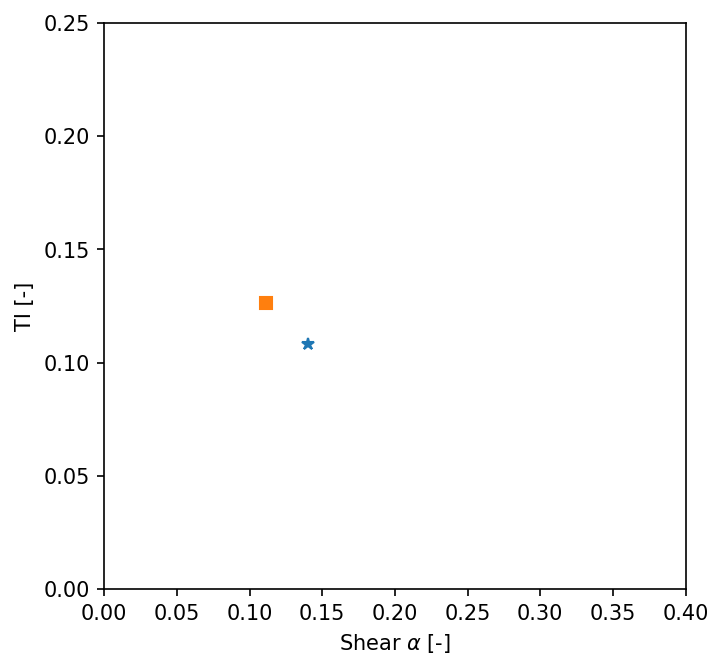

In [7]:
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)

# Plot the SWIFT data
SWIFT_alpha = 0.14
SWIFT_TI    = 0.108
plt.plot(SWIFT_alpha, SWIFT_TI, '*', label='SWIFT')

# Plot the AMR-Wind results
plt.plot(reportstats['Alpha'][0], reportstats['TI_horiz'][0], 's', label='AMR-Wind')

plt.xlim([0, 0.4])
plt.ylim([0, 0.25])
plt.xlabel(r'Shear $\alpha$ [-]')
plt.ylabel('TI [-]')

# Plot velocity profile

Loading u
Loading v


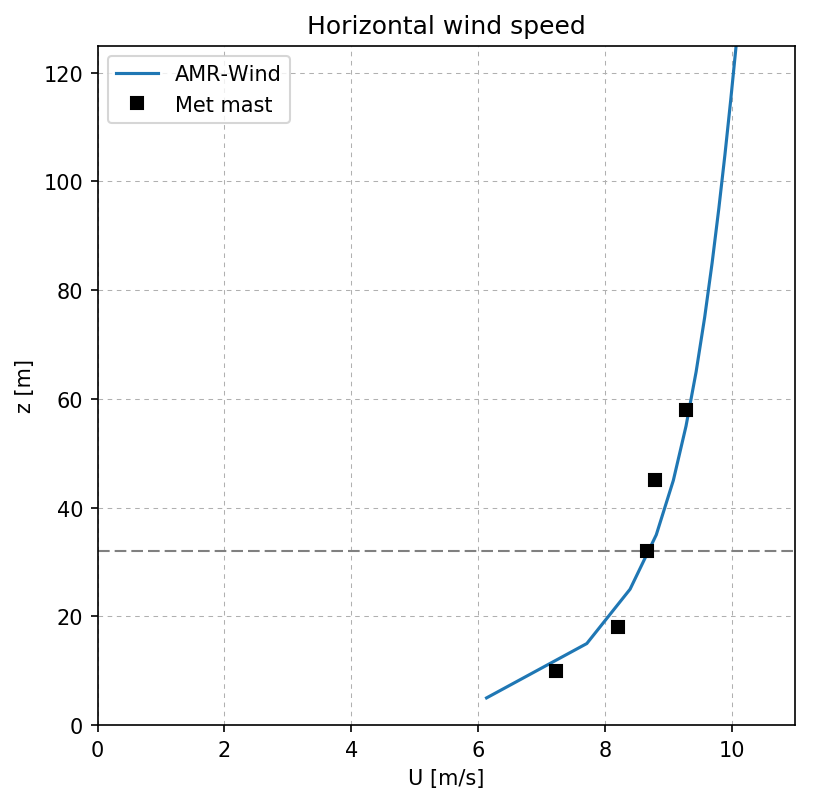

In [8]:
# Plot velocity
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command will make the plot directly onto ax
#tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['Uhoriz'], avgt=avgtimes)

# This command returns the data, and then you can plot it individually
amrdat = tutorial2.ABLpostpro_plotprofiles(plotvars=['Uhoriz'], avgt=avgtimes)
plt.plot(amrdat['Uhoriz']['data'], amrdat['Uhoriz']['z'], label='AMR-Wind')

# Plot the met mast
plt.plot(Umetvec, zmetvec, 's', color='k', label='Met mast')

# Plot the turbine dimensions
plt.hlines(plotheights[0], 0,              14, linestyles='dashed', color='gray', linewidth=1.0) # Plot the HH line

#ax.plot(DanAeroWS, DanAeroZ, 's', color='k', label='DanAero')
ax.legend()
ax.set_xlim([0, 11])
ax.set_xlabel('U [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylim([0,125])
ax.set_ylabel('z [m]')
ax.set_title('Horizontal wind speed')

# Compare AMR-Wind temperature and veer profiles

Loading theta


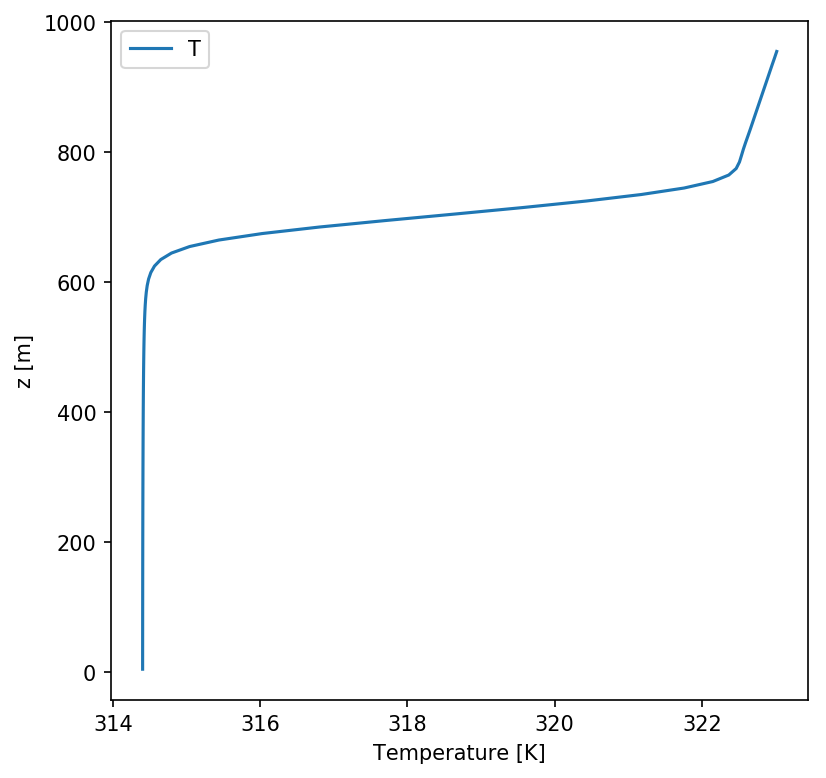

In [9]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['Temperature'], avgt=avgtimes);
ax.set_xlabel('Temperature [K]')

Loading u
Loading v


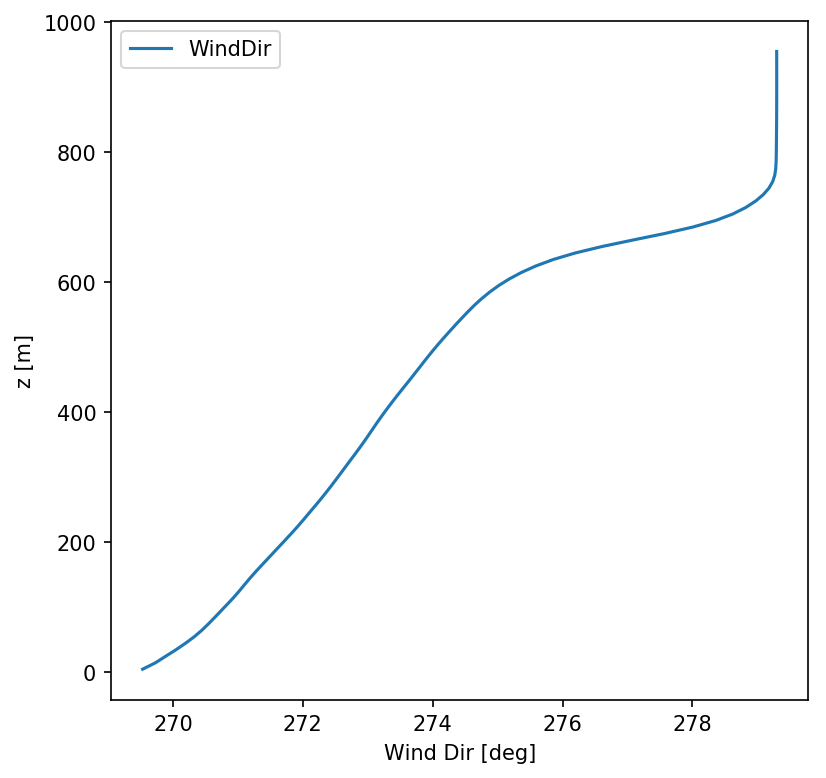

In [10]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
tutorial2.ABLpostpro_plotprofiles(ax=ax, plotvars=['WindDir'], avgt=avgtimes);
ax.set_xlabel('Wind Dir [deg]')